# Task 1: Preprocess and Explore the Data

Project: Time Series Forecasting for Portfolio Management Optimization (GMF Investments)

This notebook loads TSLA, BND, SPY from yfinance (2015-07-01 to 2025-07-31), cleans data, performs EDA, computes returns and volatility, runs ADF stationarity tests, and calculates risk metrics (VaR, Sharpe).

In [1]:
import sys
from pathlib import Path

ROOT = Path().resolve()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent 
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
print("Project root on sys.path:", ROOT)

# Standard imports
import os
import pandas as pd
import numpy as np

# Project constants and utilities
from src.constants.config import (
    TICKERS,
    START_DATE,
    END_DATE,
    INTERVAL,
    AUTO_ADJUST,
    RISK_FREE_RATE,
)
from src.utils.data_loader import fetch_yfinance_data, merge_adjusted_close
from src.utils.preprocessing import fill_missing_dates, handle_missing, compute_returns
from src.utils.eda import basic_stats, rolling_stats, detect_outliers_zscore, adf_test
from src.utils.metrics import sharpe_ratio, value_at_risk_historic, value_at_risk_parametric
from src.utils.plotting import plot_prices, plot_returns, plot_rolling

# Display settings
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

print("Config:", TICKERS, START_DATE, END_DATE, "Interval:", INTERVAL, "Auto-adjust:", AUTO_ADJUST)

Project root on sys.path: C:\Users\senta\OneDrive\Documents\Proj\10 Ac\Time-Series-Forecasting-for-Portfolio-Management-Optimization
Config: ['TSLA', 'BND', 'SPY'] 2015-07-01 2025-07-31 Interval: 1d Auto-adjust: True


In [2]:
# Fetch OHLCV data
raw = fetch_yfinance_data(TICKERS, START_DATE, END_DATE, interval=INTERVAL, auto_adjust=AUTO_ADJUST)
list(raw.keys()), [raw[k].shape for k in raw]

(['TSLA', 'BND', 'SPY'], [(2535, 5), (2535, 5), (2535, 5)])

In [3]:
# Merge Adj Close into a single DataFrame
prices = merge_adjusted_close(raw, column='Adj Close')
prices = fill_missing_dates(prices)
prices = handle_missing(prices, method='interpolate')
prices.head(), prices.isna().sum()

(Price            TSLA        BND         SPY
 2015-07-01  17.943333  60.816742  174.917099
 2015-07-02  18.667999  60.967083  174.756943
 2015-07-03  18.663000  61.019705  174.632614
 2015-07-06  18.648001  61.177570  174.259628
 2015-07-07  17.858667  61.237717  175.355438,
 Price
 TSLA    0
 BND     0
 SPY     0
 dtype: int64)

In [4]:
# 3) Robust merge with diagnostics
from src.utils.data_loader import merge_adjusted_close

def debug_merge_choice(data):
    chosen = {}
    frames = []
    for t, df in data.items():
        if df is None or df.empty:
            chosen[t] = None
            continue
        if "Adj Close" in df.columns:
            chosen[t] = "Adj Close"
            frames.append(df[["Adj Close"]].rename(columns={"Adj Close": t}))
        elif "Close" in df.columns:
            chosen[t] = "Close"
            frames.append(df[["Close"]].rename(columns={"Close": t}))
        else:
            chosen[t] = "NONE"
    merged = pd.concat(frames, axis=1).sort_index() if frames else pd.DataFrame()
    return chosen, merged

# Try original raw; if empty, try test raw
chosen_cols, prices = debug_merge_choice(raw)
print("Chosen per ticker:", chosen_cols, "| merged shape:", prices.shape)

if prices.empty:
    print("Retrying with TEST range and auto_adjust=False ...")
    chosen_cols2, prices2 = debug_merge_choice(raw_test)
    print("Chosen per ticker (TEST):", chosen_cols2, "| merged shape:", prices2.shape)
    prices = prices2  # adopt test if valid

if prices.empty:
    raise RuntimeError("No price data merged. Check connectivity, date range, and yfinance response above.")

# 4) Align calendar and fill
prices = fill_missing_dates(prices)
prices = handle_missing(prices, method="interpolate")
prices = prices.dropna(axis=1, how="all")
print("Prices after cleaning:", prices.shape)
display(prices.head())

Chosen per ticker: {'TSLA': 'Close', 'BND': 'Close', 'SPY': 'Close'} | merged shape: (2535, 3)
Prices after cleaning: (2631, 3)


Price,TSLA,BND,SPY
2015-07-01,17.943333,60.816742,174.917099
2015-07-02,18.667999,60.967083,174.756943
2015-07-03,18.663000,61.019705,174.632614
2015-07-06,18.648001,61.177570,174.259628
2015-07-07,17.858667,61.237717,175.355438


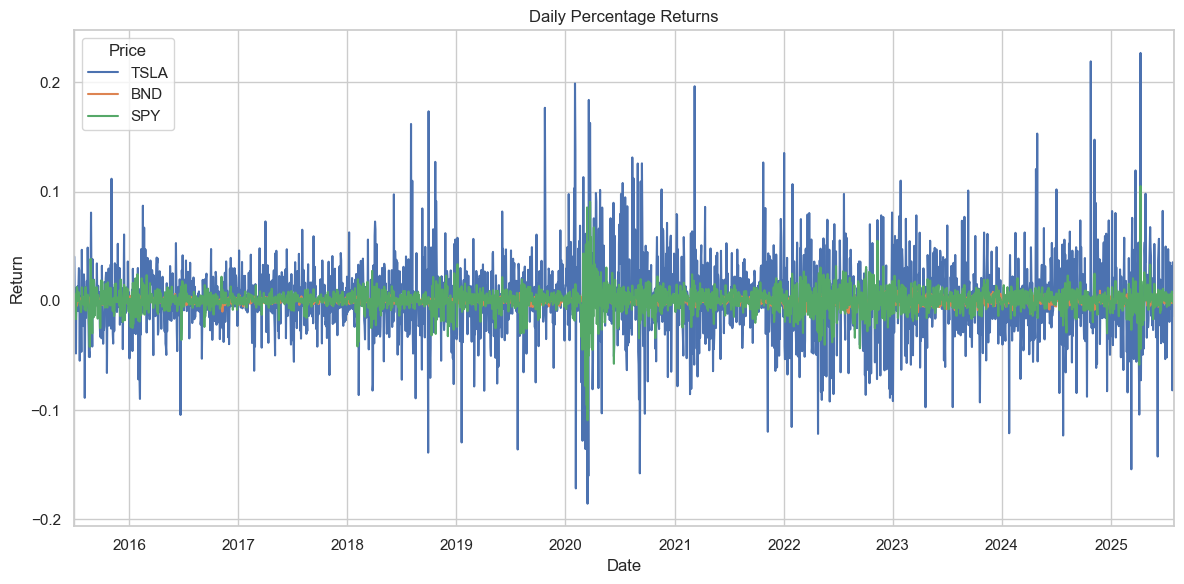

Price,TSLA,BND,SPY
count,2630.000000,2630.000000,2630.000000
mean,0.001745,0.000075,0.000553
std,0.036156,0.003371,0.011199
min,-0.185778,-0.054385,-0.109424
1%,-0.090587,-0.008674,-0.032895
5%,-0.052559,-0.004747,-0.016688
50%,0.001197,0.000126,0.000532
95%,0.057800,0.004609,0.015754
99%,0.108832,0.008323,0.026329
max,0.226900,0.042201,0.105019


In [5]:
# Compute daily returns and visualize
returns = compute_returns(prices, kind='pct')
plot_returns(returns, title='Daily Percentage Returns')
returns.describe(percentiles=[0.01,0.05,0.95,0.99])

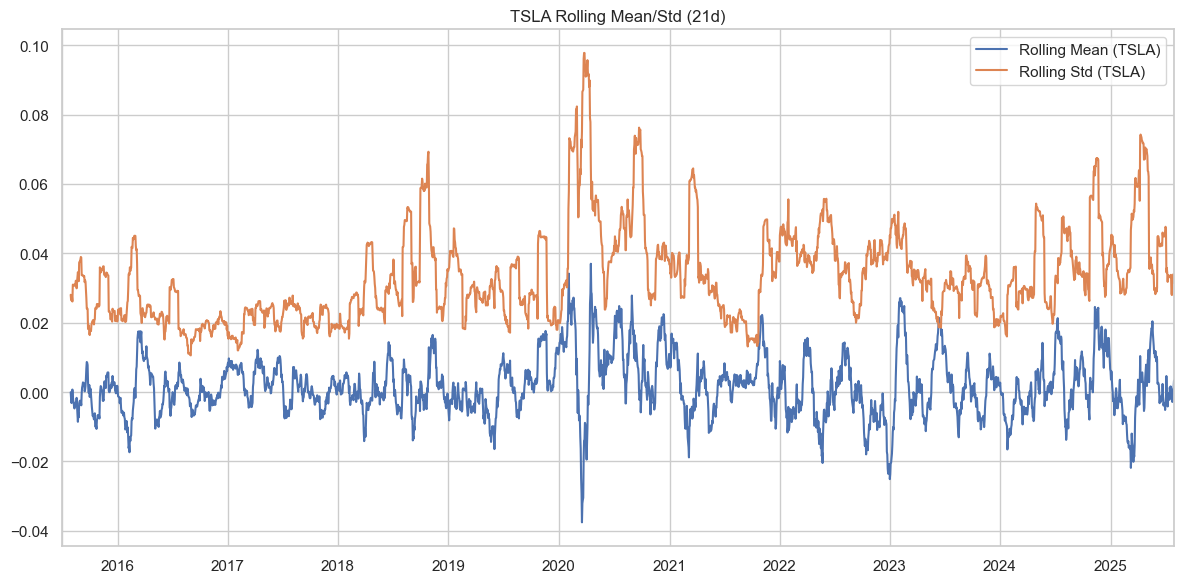

(Price           TSLA       BND       SPY
 2025-07-24 -0.002842 -0.000080  0.002105
 2025-07-25 -0.000906 -0.000099  0.001933
 2025-07-28  0.000844 -0.000067  0.001685
 2025-07-29  0.001080 -0.000007  0.001331
 2025-07-30  0.003301 -0.000095  0.001287,
 Price           TSLA       BND       SPY
 2025-07-24  0.032226  0.002335  0.004105
 2025-07-25  0.033268  0.002311  0.003926
 2025-07-28  0.033914  0.002284  0.003889
 2025-07-29  0.033790  0.002407  0.003930
 2025-07-30  0.031487  0.002468  0.003955)

In [6]:
# Rolling volatility (21-day)
roll = rolling_stats(returns, window=21)
plot_rolling(roll['mean'], roll['std'], column='TSLA', title='TSLA Rolling Mean/Std (21d)')
roll['mean'].tail(), roll['std'].tail()

In [7]:
# Outlier detection for TSLA daily returns
out_tsla = detect_outliers_zscore(returns['TSLA'], threshold=3.0)
out_tsla[out_tsla['is_outlier']].head()

,value,z,is_outlier
2015-11-04,0.111735,3.042674,True
2018-08-02,0.161880,4.429841,True
2018-09-28,-0.139015,-3.893854,True
2018-10-01,0.173471,4.750490,True
2018-10-23,0.127189,3.470179,True


In [8]:
# Stationarity tests (ADF) on prices and returns
adf_prices_tsla = adf_test(prices['TSLA'])
adf_returns_tsla = adf_test(returns['TSLA'])
adf_prices_tsla, adf_returns_tsla

({'adf_stat': np.float64(-1.4920850611664256),
  'p_value': np.float64(0.5374230492076859),
  'used_lag': 25,
  'n_obs': 2605,
  'crit_1%': np.float64(-3.4328627660143476),
  'crit_5%': np.float64(-2.86265014634789),
  'crit_10%': np.float64(-2.567360970560822)},
 {'adf_stat': np.float64(-15.617454998478415),
  'p_value': np.float64(1.7487976940121094e-28),
  'used_lag': 8,
  'n_obs': 2621,
  'crit_1%': np.float64(-3.43284741167062),
  'crit_5%': np.float64(-2.8626433656018726),
  'crit_10%': np.float64(-2.5673573604457642)})

In [9]:
# Risk metrics: VaR and Sharpe (daily to annualized)
tsla_sharpe = sharpe_ratio(returns['TSLA'], risk_free_rate=RISK_FREE_RATE, freq='daily')
tsla_var_hist_95 = value_at_risk_historic(returns['TSLA'].dropna(), alpha=0.95)
tsla_var_param_95 = value_at_risk_parametric(returns['TSLA'].dropna(), alpha=0.95)
{'TSLA_Sharpe': tsla_sharpe, 'TSLA_VaR_hist_95': tsla_var_hist_95, 'TSLA_VaR_param_95': tsla_var_param_95}

{'TSLA_Sharpe': 0.73147558863238,
 'TSLA_VaR_hist_95': -0.052559261855588874,
 'TSLA_VaR_param_95': -0.0577269523416602}